# Clasificación de Noticias con SVM

Este cuaderno aplica el algoritmo Naive Bayes para la detección de noticias falsas utilizando distintos fragmentos del texto: el título, el cuerpo completo y ambos combinados.

Para cada enfoque se realiza:
- Preparación del conjunto de datos
- Entrenamiento del modelo
- Evaluación mediante matriz de confusión y curva ROC
- Guardado del modelo entrenado

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')  # Añades esa carpeta al path
sys.path.append('../models')  # Añades esa carpeta al path
from preprocessing import preprocess
from models import train_SVM
from metrics import plot_roc_auc
from metrics import plot_feature_importance
from metrics import plot_confusion_matrix
import joblib
from pathlib import Path


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/inma/Escritorio/tfg_fakenews/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/inma/Escritorio/tfg_fakenews/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/ho

In [2]:
# Ruta a los datos 
path = '../data/processed/listo.csv' 

# Cargar CSVs
df = pd.read_csv(path, keep_default_na=False)

df

,title,text,label,news_type,lang,Cluster,category,title_length,text_length,total_length,sentences
0,law enforcement high alert following threat co...,no comment expected barack obama member fyf fu...,1,Real,en,5,sociedad,18,871,889,law enforcement high alert following threat co...
1,unbelievable exclamationtoken obamas attorney ...,most demonstrator gathered last night exercisi...,1,Real,en,5,sociedad,18,34,52,unbelievable exclamationtoken obamas attorney ...
2,bobby jindal raised hindu us story christian c...,dozen politically active pastor came private d...,0,Falsa,en,5,sociedad,16,1321,1337,bobby jindal raised hindu us story christian c...
3,satan russia unvelis image terrifying new supe...,r sarmat missile dubbed satan replace s fly mi...,1,Real,en,0,gobierno,16,329,345,satan russia unvelis image terrifying new supe...
4,time exclamationtoken christian group sue amaz...,all say one time someone sued southern poverty...,1,Real,en,5,sociedad,13,244,257,time exclamationtoken christian group sue amaz...
...,...,...,...,...,...,...,...,...,...,...,...
61844,wikileaks email show clinton foundation fund u...,email released wikileaks sunday appears show f...,1,Real,en,1,clinton,15,205,220,wikileaks email show clinton foundation fund u...
61845,russian steal research trump hack u democratic...,washington reuters hacker believed working rus...,0,Falsa,en,1,clinton,11,735,746,russian steal research trump hack u democratic...
61846,watch giuliani demand democrat apologize trump...,know fantasyland republican never questioned c...,1,Real,en,4,trump,10,604,614,watch giuliani demand democrat apologize trump...
61847,migrant refuse leave train refugee camp hungary,migrant refuse leave train refugee camp hungar...,0,Falsa,en,5,sociedad,10,477,487,migrant refuse leave train refugee camp hungar...


In [3]:
df.isnull().sum()

title           0
text            0
label           0
news_type       0
lang            0
Cluster         0
category        0
title_length    0
text_length     0
total_length    0
sentences       0
dtype: int64

### RandomForest solo titulo

In [4]:
X = df[['title', 'category']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [5]:
SVMtitle = train_SVM(X_train, y_train)
SVMtitle

Mejores parámetros encontrados: {'clf__C': 0.1, 'clf__max_iter': 3000}
Mejor accuracy promedio (cv=5): 0.8857348060258328


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('texto',
                                                  TfidfVectorizer(max_features=5000),
                                                  'title')])),
                ('clf', LinearSVC(C=0.1, max_iter=3000))])

In [6]:
predictions_title=SVMtitle.predict(X_test)
print(confusion_matrix(y_test, predictions_title))
print('\n')
print(classification_report(y_test, predictions_title))

[[9302 1020]
 [1132 7101]]


              precision    recall  f1-score   support

           0       0.89      0.90      0.90     10322
           1       0.87      0.86      0.87      8233

    accuracy                           0.88     18555
   macro avg       0.88      0.88      0.88     18555
weighted avg       0.88      0.88      0.88     18555



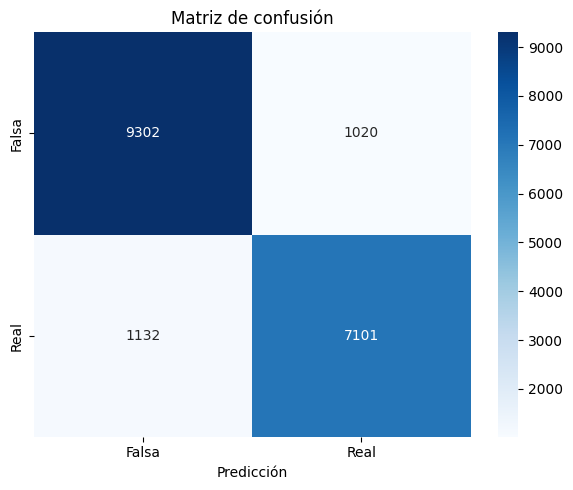

In [7]:
plot_confusion_matrix(y_test, predictions_title)

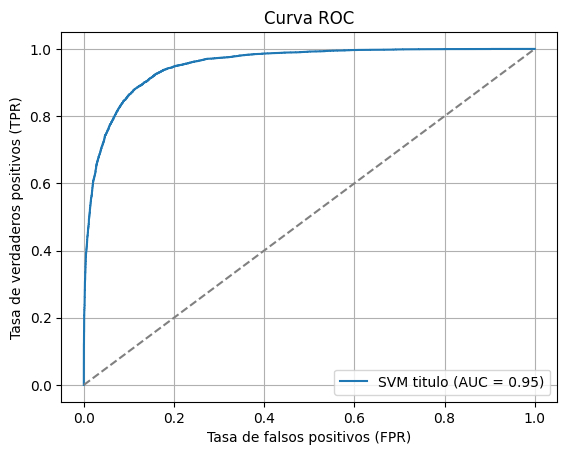

In [8]:
plot_roc_auc(SVMtitle, X_test, y_test, label='SVM titulo')

### SVM solo con el texto

In [9]:
X = df[['text', 'category']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


In [10]:
SVMbody = train_SVM(X_train, y_train)

predictions_body=SVMbody.predict(X_test)
print(confusion_matrix(y_test, predictions_body))
print('\n')
print(classification_report(y_test, predictions_body))

Mejores parámetros encontrados: {'clf__C': 1, 'clf__max_iter': 3000}
Mejor accuracy promedio (cv=5): 0.9369889473365625
[[9793  529]
 [ 552 7681]]


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10322
           1       0.94      0.93      0.93      8233

    accuracy                           0.94     18555
   macro avg       0.94      0.94      0.94     18555
weighted avg       0.94      0.94      0.94     18555



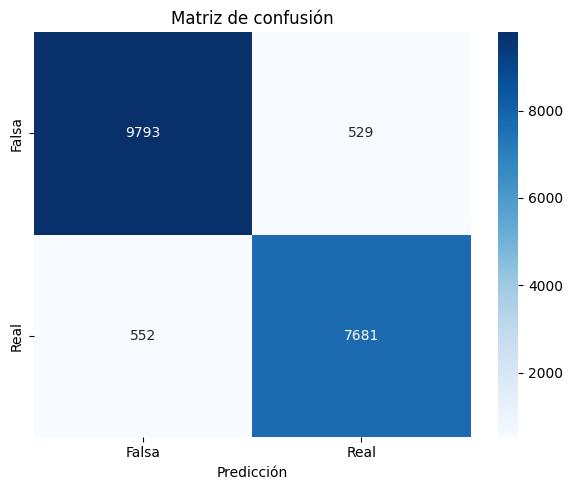

In [11]:
plot_confusion_matrix(y_test, predictions_body)

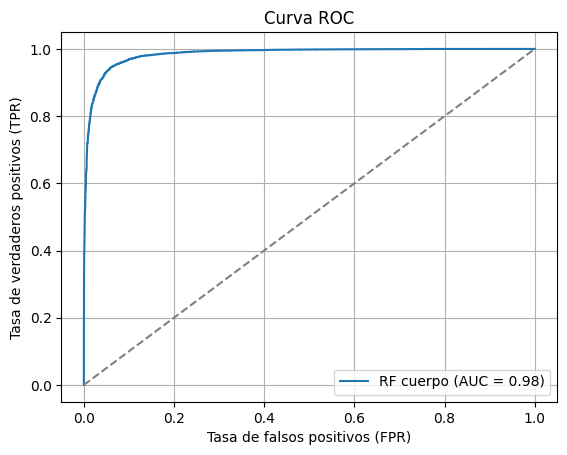

In [12]:
plot_roc_auc(SVMbody, X_test, y_test, label='RF cuerpo')

### SVM con titulo y cuerpo

In [13]:
X = df[['sentences', 'category']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


In [14]:
SVMtotal = train_SVM(X_train, y_train)

predictions_total=SVMtotal.predict(X_test)
print(confusion_matrix(y_test, predictions_total))
print('\n')
print(classification_report(y_test, predictions_total))

Mejores parámetros encontrados: {'clf__C': 1, 'clf__max_iter': 3000}
Mejor accuracy promedio (cv=5): 0.942740319539026
[[9871  451]
 [ 502 7731]]


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10322
           1       0.94      0.94      0.94      8233

    accuracy                           0.95     18555
   macro avg       0.95      0.95      0.95     18555
weighted avg       0.95      0.95      0.95     18555



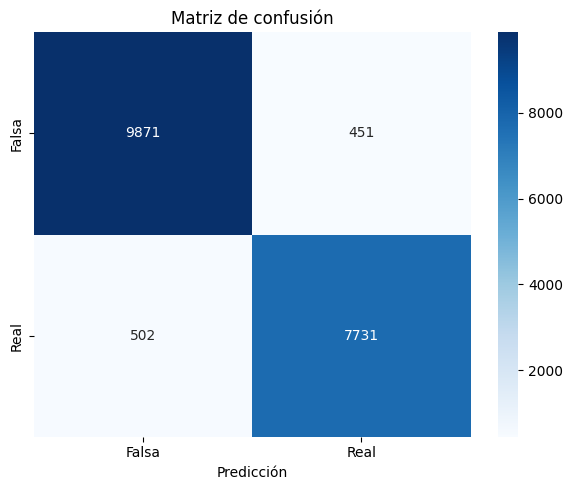

In [15]:
plot_confusion_matrix(y_test, predictions_total)

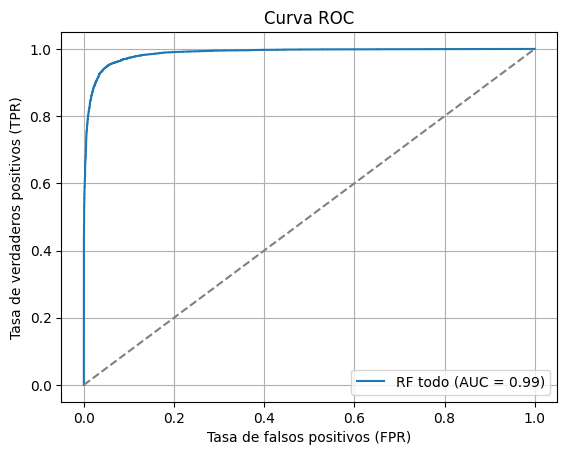

In [16]:
plot_roc_auc(SVMtotal, X_test, y_test, label='RF todo')

In [17]:
save_model(SVMtitle, 'SVM_title')
save_model(SVMbody, 'SVM_body')
save_model(SVMtotal, 'SVM_total')

NameError: name 'save_model' is not defined